## ** PREDICTIVE MAINTENANCE **

Preprocesing

In [1]:
import pandas as pd
import numpy as np
import os
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer # Import KNNImputer
import warnings
import joblib

# Nonaktifkan warning
warnings.filterwarnings('ignore')

print("--- [1: PREPROCESSING DATA] ---")

# ----------------------------------------------------------------------
## 1-3. Data Loading & Quality Assessment
# ----------------------------------------------------------------------
print(" Memulai Tahap 1-3: Data Loading & Quality Assessment...")

try:
    df1 = pd.read_csv("/content/ai4i2020.csv")
    df2 = pd.read_csv("/content/data.csv")
    df3 = pd.read_csv("/content/predictive-maintenance-dataset.csv")

    df1.rename(columns={'UDI': 'ID'}, inplace=True)
    df2.rename(columns={'id': 'ID'}, inplace=True)
    df3.rename(columns={'UDI': 'ID'}, inplace=True)

except FileNotFoundError as e:
    print(f" ERROR: Pastikan file CSV tersedia. Detail: {e}")
    exit()

# ----------------------------------------------------------------------
## 4.  Data Cleaning & Feature Aggregation (Menghapus Imputasi Statis)
# ----------------------------------------------------------------------
print("\n Memulai Tahap 4: Data Cleaning & Feature Aggregation...")

df2_agg = df2.groupby('ID').mean(numeric_only=True).reset_index()
df3_agg = df3.groupby('ID').mean(numeric_only=True).reset_index()

merged = pd.merge(df1, df2_agg, on='ID', how='left')
merged = pd.merge(merged, df3_agg, on='ID', how='left')

# PENTING: KAMI TIDAK MELAKUKAN IMPUTASI STATIS DI SINI.
# Imputasi akan dilakukan oleh KNNImputer di Tahap 7.
# print("   - Imputasi statis dihindari; KNNImputer akan digunakan di pipeline.")


# ----------------------------------------------------------------------
## 5. Feature Engineering & Reduction (Mode Prediktif)
# ----------------------------------------------------------------------
print("\n Memulai Tahap 5: Feature Engineering & Reduction (Mode Prediktif)...")

binary_failure_features = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Hapus fitur-fitur yang menyebabkan data leakage
X = merged.drop(columns=['Machine failure', 'Product ID', 'ID'] + binary_failure_features)
y = merged['Machine failure']

print(f"   - Jumlah Fitur Input (X): {len(X.columns)}")

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

core_features = ['Air temperature [K]', 'Process temperature [K]',
                 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

pca_features = [col for col in num_features if col not in core_features]
standard_num_features = core_features


# ----------------------------------------------------------------------
## 6. Data Validation & Train Test Split
# ----------------------------------------------------------------------
print("\n Tahap 6: Data Validation (Lanjut) & Train Test Split...")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"   - Ukuran Data Training (X_train): {X_train.shape}")


# ----------------------------------------------------------------------
## 7. Preprocessing Pipeline (Integrasi KNNImputer)
# ----------------------------------------------------------------------
print("\n Memulai Tahap 7: Preprocessing Pipeline (Integrasi KNNImputer)...")

# --- Sub-Pipeline Numerik ---
# Sub-pipeline untuk imputasi, scaling, dan PCA
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)), # <--- KNNImputer DITERAPKAN DI SINI
    ('scaler', StandardScaler())
])

# Sub-pipeline untuk PCA
pca_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)), # <--- KNNImputer DITERAPKAN DI SINI
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.90))
])

# Transformer untuk Fitur Kategorikal (OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    # Data kategorikal tidak memiliki NaN setelah merge, tetapi jika ada,
    # OneHotEncoder(handle_unknown='ignore') menanganinya atau bisa ditambah SimpleImputer(strategy='constant', fill_value='missing')
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column Transformer (Preprocessor)
preprocessor = ColumnTransformer(
    transformers=[
        ('pca_num', pca_transformer, pca_features),
        ('std_num', numeric_transformer, standard_num_features), # Gunakan numeric_transformer yang sudah ada KNNImputer
        ('cat', categorical_transformer, cat_features)
    ],
    remainder='drop'
)
print("   - Preprocessor (KNNImputer -> StandardScaler -> PCA/OHE) berhasil dibuat.")

# ----------------------------------------------------------------------
## 8. Data Drift Detection & Final Summary
# ----------------------------------------------------------------------
print("\n Tahap 8 : Placeholder dan Ringkasan. Siap menuju Machine Learning.")

X_train_transformed = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()

joblib.dump(preprocessor, 'preprocessor_pm_knn.pkl')

print(f"\n--- Jumlah Fitur Sebelum Preprocessing: {X_train.shape[1]}")
print(f"--- Jumlah Fitur Setelah Preprocessing: {X_train_transformed.shape[1]}")
print("---------------------------------------------------------------------")

--- [1: PREPROCESSING DATA] ---
 Memulai Tahap 1-3: Data Loading & Quality Assessment...

 Memulai Tahap 4: Data Cleaning & Feature Aggregation...

 Memulai Tahap 5: Feature Engineering & Reduction (Mode Prediktif)...
   - Jumlah Fitur Input (X): 34

 Tahap 6: Data Validation (Lanjut) & Train Test Split...
   - Ukuran Data Training (X_train): (8000, 34)

 Memulai Tahap 7: Preprocessing Pipeline (Integrasi KNNImputer)...
   - Preprocessor (KNNImputer -> StandardScaler -> PCA/OHE) berhasil dibuat.

 Tahap 8 : Placeholder dan Ringkasan. Siap menuju Machine Learning.

--- Jumlah Fitur Sebelum Preprocessing: 34
--- Jumlah Fitur Setelah Preprocessing: 13
---------------------------------------------------------------------


PEMBENTUKAN MACHINE LEARNING XGBOOST

--- [BLOK 2a: MACHINE LEARNING - XGBOOST + SMOTE + KNNIMPUTER] ---
Melatih Model XGBoost dengan SMOTE...
Pelatihan Selesai.

--- HASIL EVALUASI KINERJA MODEL (XGBOOST) ---

| SET DATA PELATIHAN (TRAINING)
| Akurasi Total: 0.9391
| Recall: 1.0000
| F1-Score: 0.5267

| SET DATA PENGUJIAN (TESTING)
| Akurasi Total: 0.9280
| Recall: 0.8971
| F1-Score: 0.4586
| AUC-ROC: 0.9707

Pipeline XGBoost dengan KNNImputer telah disimpan.


<Figure size 800x800 with 0 Axes>

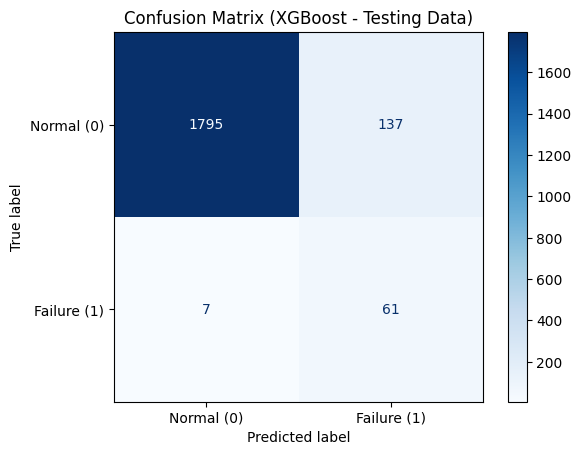

In [7]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np

# Variabel X_train, y_train, X_test, y_test, preprocessor diambil dari Blok 1

print("--- [BLOK 2a: MACHINE LEARNING - XGBOOST + SMOTE + KNNIMPUTER] ---")

# 1. Tentukan Class Weight untuk Model
scale_pos_weight_value = (y_train.value_counts()[0] / y_train.value_counts()[1])

# 2. Definisi Model XGBoost
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight_value,
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    gamma=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

# 3. Pembentukan Imblearn Pipeline
smote = SMOTE(random_state=42)
full_pipeline_xgb = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('model', xgb_model)
])

# 4. Pelatihan Model
print("Melatih Model XGBoost dengan SMOTE...")
full_pipeline_xgb.fit(X_train, y_train)
print("Pelatihan Selesai.")

# --- 5. Evaluasi Model pada Data TRAINING dan TESTING ---
y_pred_test = full_pipeline_xgb.predict(X_test)
y_proba_test = full_pipeline_xgb.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test, pos_label=1)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)
roc_auc_test = roc_auc_score(y_test, y_proba_test)

y_pred_train = full_pipeline_xgb.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train, pos_label=1)
f1_train = f1_score(y_train, y_pred_train, pos_label=1)


# 6. Tampilkan Hasil
print("\n--- HASIL EVALUASI KINERJA MODEL (XGBOOST) ---")

print("\n| SET DATA PELATIHAN (TRAINING)")
print(f"| Akurasi Total: {acc_train:.4f}")
print(f"| Recall: {recall_train:.4f}")
print(f"| F1-Score: {f1_train:.4f}")

print("\n| SET DATA PENGUJIAN (TESTING)")
print(f"| Akurasi Total: {acc_test:.4f}")
print(f"| Recall: {recall_test:.4f}")
print(f"| F1-Score: {f1_test:.4f}")
print(f"| AUC-ROC: {roc_auc_test:.4f}")

# 7. Simpan pipeline
joblib.dump(full_pipeline_xgb, 'maintenance_pipeline_xgb_knn.pkl')
print("\nPipeline XGBoost dengan KNNImputer telah disimpan.")

# 8. Visualisasi Confusion Matrix (Diperbaiki)
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (0)', 'Failure (1)'])
plt.figure(figsize=(8, 8)) # Membuat figure
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix (XGBoost - Testing Data)')
plt.grid(False)
plt.show() # Tampilkan plot setelah dibuat

IMPLEMENTASI MODEL (DATA INPUT)

In [3]:
import pandas as pd
import joblib
import numpy as np

# --- Asumsi Variabel Global dari Blok Preprocessing ---
# Anda harus memiliki variabel X (dataframe fitur sebelum split) dan merged
# (dataframe gabungan sebelum cleanup) dari Blok 1 untuk mendapatkan daftar kolom dan nilai mean.
try:
    # Muat pipeline yang sudah dilatih dan preprocessor
    full_pipeline = joblib.load('maintenance_pipeline_xgb_knn.pkl')
    # Muat preprocessor terpisah untuk mendapatkan daftar fitur dan nilai mean
    preprocessor = joblib.load('preprocessor_pm_knn.pkl')

    # Asumsi: X dan merged tersedia di lingkungan
    # Jika tidak, Anda perlu memuatnya dari file atau menghitungnya kembali
    mean_values = merged.mean(numeric_only=True)

    print(" Pipeline dan Data Referensi berhasil dimuat.")

except Exception as e:
    print(f" ERROR: Gagal memuat file atau variabel referensi. Pastikan Blok 1 dan Blok 2 telah dijalankan dan file disimpan. Detail: {e}")
    exit()

# Daftar fitur inti yang harus diinput pengguna
core_feature_list = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'Type'
]

# --- 1. Input Data Utama dari Pengguna ---
print("\n--- INPUT DATA MESIN BARU (Gunakan Titik '.' untuk Desimal) ---")

user_input = {}
try:
    # 1. Input Fitur Numerik
    user_input['Air temperature [K]'] = float(input("1. Air temperature [K] (Contoh: 300.5): "))
    user_input['Process temperature [K]'] = float(input("2. Process temperature [K] (Contoh: 310.5): "))
    user_input['Rotational speed [rpm]'] = float(input("3. Rotational speed [rpm] (Contoh: 1500): "))
    user_input['Torque [Nm]'] = float(input("4. Torque [Nm] (Contoh: 45.0): "))
    user_input['Tool wear [min]'] = float(input("5. Tool wear [min] (Contoh: 110): "))

    # 2. Input Fitur Kategorikal
    type_input = input("6. Type (L, M, atau H): ").upper()
    if type_input not in ['L', 'M', 'H']:
        print(" Peringatan: Type tidak valid, menggunakan 'M' sebagai default.")
        user_input['Type'] = 'M'
    else:
        user_input['Type'] = type_input

except ValueError:
    print(" ERROR: Input numerik tidak valid. Pastikan Anda memasukkan angka.")
    exit()


# --- 2. Pembentukan DataFrame Input Akhir ---

# 2.1 Konversi input pengguna ke DataFrame
df_input_base = pd.DataFrame([user_input])

# 2.2 Tambahkan Fitur Agregasi (Placeholder Mean)
# Identifikasi fitur yang harus diisi dengan mean (fitur non-core yang tersisa di X)
features_to_fill = [col for col in X.columns.tolist() if col not in core_feature_list]

for feature in features_to_fill:
    # Menggunakan nilai mean dari data historis
    if feature in mean_values:
        df_input_base[feature] = mean_values[feature]
    else:
        # Jika ada fitur agregasi yang tidak ada di mean_values (sangat jarang terjadi), gunakan 0
        df_input_base[feature] = 0

# 2.3 Re-order kolom agar sesuai dengan urutan X_train (Wajib)
df_new_X = df_input_base[X.columns.tolist()]
print(f" Data input baru memiliki {df_new_X.shape[1]} fitur dan siap diprediksi.")


# --- 3. Prediksi ---
print("\n--- HASIL PREDIKSI ---")

# Prediksi Kelas (0 atau 1)
prediction = full_pipeline.predict(df_new_X)[0]

# Prediksi Probabilitas (Probabilitas Kegagalan = 1)
probability = full_pipeline.predict_proba(df_new_X)[0, 1]

# Interpretasi Hasil
status = "**KEGAGALAN DIPREDIKSI (1)**" if prediction == 1 else "OPERASI NORMAL (0)"

print(f"Berdasarkan kondisi input, model memprediksi: {status}")
print(f"Probabilitas Kegagalan (P=1): {probability:.4f}")

if probability > 0.5 and prediction == 1:
    print(" **Tindakan yang Disarankan:** Segera lakukan pemindaian dan pemeliharaan pencegahan untuk mencegah kegagalan total.")
else:
    print(" **Tindakan yang Disarankan:** Mesin beroperasi dalam batas normal. Lanjutkan pemantauan rutin.")

# --- Akhir Kode ---

 Pipeline dan Data Referensi berhasil dimuat.

--- INPUT DATA MESIN BARU (Gunakan Titik '.' untuk Desimal) ---
1. Air temperature [K] (Contoh: 300.5): 300
2. Process temperature [K] (Contoh: 310.5): 320
3. Rotational speed [rpm] (Contoh: 1500): 1200
4. Torque [Nm] (Contoh: 45.0): 53
5. Tool wear [min] (Contoh: 110): 119
6. Type (L, M, atau H): l
 Data input baru memiliki 34 fitur dan siap diprediksi.

--- HASIL PREDIKSI ---
Berdasarkan kondisi input, model memprediksi: OPERASI NORMAL (0)
Probabilitas Kegagalan (P=1): 0.0015
 **Tindakan yang Disarankan:** Mesin beroperasi dalam batas normal. Lanjutkan pemantauan rutin.


PEMBENTUKAN MACHINE LEARNING RANDOM FOREST

--- [BLOK 2b: MACHINE LEARNING - RANDOM FOREST + SMOTE] ---
Melatih Model Random Forest dengan SMOTE...
Pelatihan Selesai.

--- HASIL EVALUASI KINERJA MODEL (RANDOM FOREST) ---

| SET DATA PELATIHAN (TRAINING)
| Akurasi Total: 0.9832
| Recall: 0.9779
| F1-Score: 0.7982

| SET DATA PENGUJIAN (TESTING)
| Akurasi Total: 0.9635
| Recall: 0.7794
| F1-Score: 0.5922
| AUC-ROC: 0.9654

Pipeline Random Forest telah disimpan.


<Figure size 800x800 with 0 Axes>

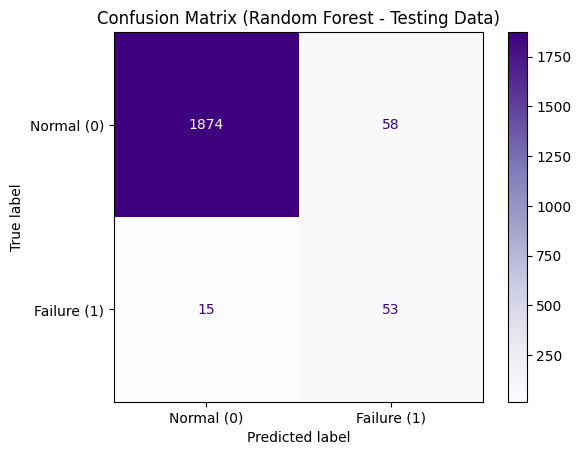

In [9]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np

# Variabel X_train, y_train, X_test, y_test, preprocessor diambil dari Blok 1

print("--- [BLOK 2b: MACHINE LEARNING - RANDOM FOREST + SMOTE] ---")

# 1. Definisi Model Random Forest
rf_model = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# 2. Pembentukan Imblearn Pipeline
smote = SMOTE(random_state=42)
full_pipeline_rf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('model', rf_model)
])

# 3. Pelatihan Model
print("Melatih Model Random Forest dengan SMOTE...")
full_pipeline_rf.fit(X_train, y_train)
print("Pelatihan Selesai.")

# --- 4. Evaluasi Model pada Data TRAINING dan TESTING ---
y_pred_test = full_pipeline_rf.predict(X_test)
y_proba_test = full_pipeline_rf.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test, pos_label=1)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)
roc_auc_test = roc_auc_score(y_test, y_proba_test)

y_pred_train = full_pipeline_rf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train, pos_label=1)
f1_train = f1_score(y_train, y_pred_train, pos_label=1)


# 5. Tampilkan Hasil
print("\n--- HASIL EVALUASI KINERJA MODEL (RANDOM FOREST) ---")

print("\n| SET DATA PELATIHAN (TRAINING)")
print(f"| Akurasi Total: {acc_train:.4f}")
print(f"| Recall: {recall_train:.4f}")
print(f"| F1-Score: {f1_train:.4f}")

print("\n| SET DATA PENGUJIAN (TESTING)")
print(f"| Akurasi Total: {acc_test:.4f}")
print(f"| Recall: {recall_test:.4f}")
print(f"| F1-Score: {f1_test:.4f}")
print(f"| AUC-ROC: {roc_auc_test:.4f}")

# 6. Simpan pipeline
joblib.dump(full_pipeline_rf, 'maintenance_pipeline_rf_knn.pkl')
print("\nPipeline Random Forest telah disimpan.")

# 7. Visualisasi Confusion Matrix (Diperbaiki)
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (0)', 'Failure (1)'])
plt.figure(figsize=(8, 8)) # Membuat figure
disp.plot(cmap=plt.cm.Purples, values_format='d')
plt.title('Confusion Matrix (Random Forest - Testing Data)')
plt.grid(False)
plt.show() # Tampilkan plot setelah dibuat

IMPLEMENTASI MODEL (DATA INPUT)

In [ ]:
import pandas as pd
import joblib
import numpy as np

# --- Asumsi Variabel Global dari Blok Preprocessing ---
# Variabel X dan merged harus tersedia dari sesi sebelumnya untuk mendapatkan daftar fitur dan nilai mean.

try:
    # Muat pipeline Random Forest yang sudah dilatih
    full_pipeline_rf = joblib.load('maintenance_pipeline_rf_knn.pkl')

    # Asumsi: X (Feature set sebelum split) dan merged (Data gabungan) tersedia
    mean_values = merged.mean(numeric_only=True)

    print(" Pipeline Random Forest dan Data Referensi berhasil dimuat.")

except Exception as e:
    print(f" ERROR: Gagal memuat file atau variabel referensi. Pastikan Blok 1 dan Blok 2 (Random Forest) telah dijalankan dan file disimpan. Detail: {e}")
    exit()

# Daftar fitur inti yang harus diinput pengguna
core_feature_list = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'Type'
]

# --- 1. Input Data Utama dari Pengguna ---
print("\n--- INPUT DATA MESIN BARU (Gunakan Titik '.' untuk Desimal) ---")

user_input = {}
try:
    # Input Fitur Numerik
    user_input['Air temperature [K]'] = float(input("1. Air temperature [K] (Contoh: 300.5): "))
    user_input['Process temperature [K]'] = float(input("2. Process temperature [K] (Contoh: 310.5): "))
    user_input['Rotational speed [rpm]'] = float(input("3. Rotational speed [rpm] (Contoh: 1500): "))
    user_input['Torque [Nm]'] = float(input("4. Torque [Nm] (Contoh: 45.0): "))
    user_input['Tool wear [min]'] = float(input("5. Tool wear [min] (Contoh: 110): "))

    # Input Fitur Kategorikal
    type_input = input("6. Type (L, M, atau H): ").upper()
    if type_input not in ['L', 'M', 'H']:
        print(" Peringatan: Type tidak valid, menggunakan 'M' sebagai default.")
        user_input['Type'] = 'M'
    else:
        user_input['Type'] = type_input

except ValueError:
    print(" ERROR: Input numerik tidak valid. Pastikan Anda memasukkan angka.")
    exit()


# --- 2. Pembentukan DataFrame Input Akhir ---

# 2.1 Konversi input pengguna ke DataFrame
df_input_base = pd.DataFrame([user_input])

# 2.2 Tambahkan Fitur Agregasi (Placeholder Mean)
# Identifikasi fitur yang harus diisi dengan mean (fitur non-core yang tersisa di X)
features_to_fill = [col for col in X.columns.tolist() if col not in core_feature_list]

for feature in features_to_fill:
    # Menggunakan nilai mean dari data historis sebagai placeholder untuk fitur yang akan di-PCA
    if feature in mean_values:
        df_input_base[feature] = mean_values[feature]
    else:
        df_input_base[feature] = 0 # Fallback

# 2.3 Re-order kolom agar sesuai dengan urutan X_train (Wajib)
df_new_X = df_input_base[X.columns.tolist()]
print(f" Data input baru memiliki {df_new_X.shape[1]} fitur dan siap diprediksi.")


# --- 3. Prediksi ---
print("\n--- HASIL PREDIKSI (Random Forest) ---")

# Prediksi Kelas (0 atau 1)
prediction = full_pipeline_rf.predict(df_new_X)[0]

# Prediksi Probabilitas (Probabilitas Kegagalan = 1)
probability = full_pipeline_rf.predict_proba(df_new_X)[0, 1]

# Interpretasi Hasil
status = "**KEGAGALAN DIPREDIKSI (1)**" if prediction == 1 else "OPERASI NORMAL (0)"

print(f"Berdasarkan kondisi input, model memprediksi: {status}")
print(f"Probabilitas Kegagalan (P=1): {probability:.4f}")

if probability > 0.5 and prediction == 1:
    print(" Tindakan yang Disarankan: Model memprediksi risiko tinggi. Segera lakukan pemeliharaan pencegahan.")
else:
    print(" Tindakan yang Disarankan: Mesin beroperasi dalam batas normal. Lanjutkan pemantauan rutin.")

# --- Akhir Kode ---

 Pipeline Random Forest dan Data Referensi berhasil dimuat.

--- INPUT DATA MESIN BARU (Gunakan Titik '.' untuk Desimal) ---
1. Air temperature [K] (Contoh: 300.5): 250
2. Process temperature [K] (Contoh: 310.5): 300
3. Rotational speed [rpm] (Contoh: 1500): 1200
4. Torque [Nm] (Contoh: 45.0): 50
5. Tool wear [min] (Contoh: 110): 110
6. Type (L, M, atau H): m
 Data input baru memiliki 34 fitur dan siap diprediksi.

--- HASIL PREDIKSI (Random Forest) ---
Berdasarkan kondisi input, model memprediksi: OPERASI NORMAL (0)
Probabilitas Kegagalan (P=1): 0.0613
 Tindakan yang Disarankan: Mesin beroperasi dalam batas normal. Lanjutkan pemantauan rutin.
